<a href="https://colab.research.google.com/github/doantronghieu/DEEP-LEARNING/blob/main/CSR_TF_Dev_Pro_Cert/C4/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, optimizers, metrics, models, Model

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

def trend(time, slope = 0):
    return (slope * time)

def seasonal_pattern(season_time):
    """ Just an arbitrary pattern, you can change it if you wish """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """ Repeats the same pattern at each period """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time        = np.arange(4 * 365 + 1, dtype = "float32")
series      = trend(time, slope = 0.1)  
baseline    = 10
amplitude   = 40
slope       = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train    = series[:split_time]
x_valid    = series[split_time:]

window_size         = 20
batch_size          = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset, '\n')

l0    = layers.Dense(1, input_shape = [window_size])
model = models.Sequential([l0])
model.compile(loss = losses.mse,
              optimizer = optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))
model.fit(dataset, epochs = 100, verbose = 0)

print(f'Layer weights:\n{l0.get_weights()}')

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))> 

Layer weights:
[array([[-0.10072844],
       [ 0.01613646],
       [ 0.12338705],
       [-0.02155364],
       [-0.02553203],
       [-0.03313681],
       [ 0.03885672],
       [ 0.05083626],
       [-0.06680075],
       [ 0.02833594],
       [-0.04638777],
       [ 0.00056309],
       [ 0.01582948],
       [ 0.03121732],
       [-0.01766077],
       [ 0.09409292],
       [ 0.04290164],
       [ 0.12410069],
       [ 0.28154984],
       [ 0.4481412 ]], dtype=float32), array([0.01668668], dtype=float32)]


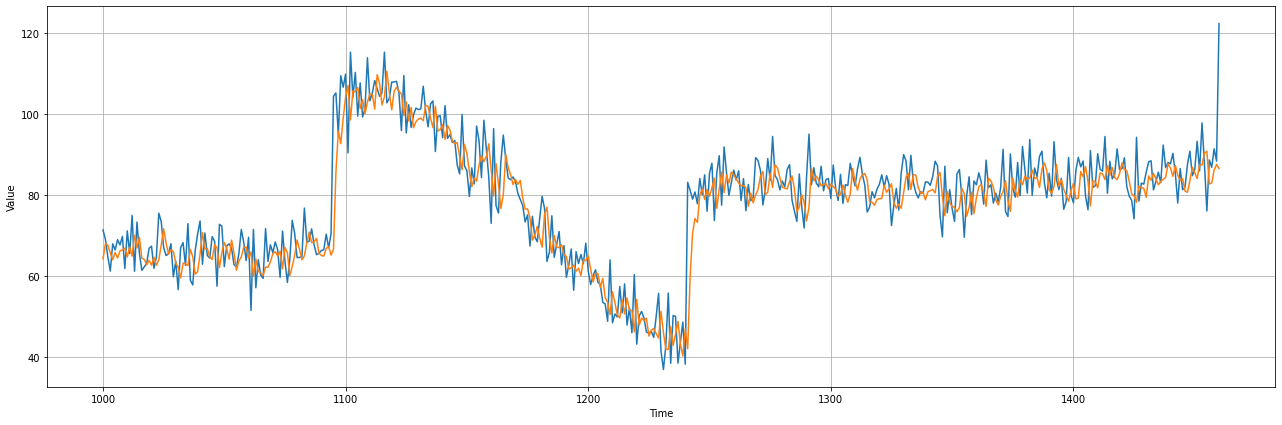

In [6]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
print(f'Error: {metrics.mean_absolute_error(x_valid, results).numpy()}')

Error: 5.072048187255859
